# NiftyPET Example

This is a full demo of NiftyPET's default [OSEM](#OSEM "ordered subsets expectation maximisation") ($n_\text{max}=14$ subsets, span 11, Siemens Biograph mMR resolution), as well as a custom, explicit [MLEM](#MLEM "maximum likelihood expectation maximisation") incorporating RM (resolution modelling).

Mathematically:

$$
{\bf\theta}^{(k+1)} = {{\bf\theta}^{(k)} \over \sum_n{{\bf H}^T{\bf X}_n^T{\bf A}^T{\bf N}^T{\bf 1}}}
    \circ
    \sum_n{ {\bf H}^T{\bf X}_n^T{\bf A}^T{\bf N}^T
        { {\bf m} \over {\bf NA}{\bf X}_n{\bf H}{\bf\theta}^{(k)} + {\bf r} + {\bf s} }
    },
$$

- $k$ is iteration number
- $H$ applies a Gaussian PSF
- $X_n$ is the system matrix for subset $n$ (MLEM has just one subset)
- $m, r, s$ are measured, randoms, and scatter

----

- Author: Casper O. da Costa-Luis [casper.dcl@{physics.org|ieee.org|kcl.ac.uk}](mailto:casper.dcl@physics.org)
- Date: 2019-21

----

## Imports

In addition to NiftyPET, this is recommended:
```bash
pip install brainweb  # basic registration
pip install spm12     # MATLAB-based registration
```

In [1]:
# imports & helper functions
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict
from glob import glob
from os import path
import functools
import logging
import os
from miutil.plot import apply_cmap, imscroll
from niftypet import nipet
from niftypet.nimpa import getnii
from scipy.ndimage.filters import gaussian_filter
from tqdm.auto import trange
import numpy as np
import pydicom

logging.basicConfig(level=logging.INFO)
print(nipet.gpuinfo())
# get all the scanner parameters
mMRpars = nipet.get_mmrparams()
# conversion for Gaussian sigma/[voxel] to FWHM/[mm]
SIGMA2FWHMmm = (8 * np.log(2))**0.5 * np.array([mMRpars['Cnt']['SO_VX' + i] for i in 'ZYX']) * 10

def div_nzer(x, y):
    return np.divide(x, y, out=np.zeros_like(y), where=y!=0)

def trimVol(x):
    return x[:, 100:-100, 100:-100]

def mapVol(vol, cmap=None, vmin=0, vmax=None):
    msk = ~np.isnan(vol)
    if vmin is None:
        vmin = vol[msk].min()
    if vmax is None:
        vmax = vol[msk].max()
    vol = (np.clip(vol, vmin, vmax) - vmin) / (vmax - vmin)
    return apply_cmap(**{cmap: vol}) if cmap is not None else vol

def register_spm(ref_file, mov_file, opth):
    """
    ref_file  : e.g. recon['fpet']
    mov_file  : e.g. datain['T1nii']
    """
    from spm12.regseg import coreg_spm, resample_spm
    reg = coreg_spm(ref_file, mov_file, outpath=opth, save_arr=False, save_txt=False)
    return getnii(resample_spm(ref_file, mov_file, reg['affine'], outpath=opth,
                               del_ref_uncmpr=True, del_flo_uncmpr=True, del_out_uncmpr=True))

def register_dipy(ref_file, mov_file, ROI=None):
    """
    ref_file  : e.g. recon['fpet']
    mov_file  : e.g. datain['T1nii']
    """
    from brainweb import register
    return register(getnii(mov_file), getnii(ref_file), ROI=ROI or ((0, None), (100, -100), (100, -100)))

[('GeForce GTX 1070 with Max-Q Design', 8119, 6, 1)]


## Load & Process Raw Data

In [2]:
folderin = "Ab_PET_mMR_test"
folderout = "."  # realtive to `{folderin}/niftyout`
itr = 7  # number of iterations (will be multiplied by 14 for MLEM)
fwhm = 2.5  # mm (for resolution modelling)
totCnt = None  # bootstrap sample (e.g. `300e6`) counts

In [3]:
# datain
folderin = path.expanduser(folderin)

# automatically categorise the input data
datain = nipet.classify_input(folderin, mMRpars, recurse=-1)

# output path
opth = path.join(datain['corepath'], "niftyout")

datain

INFO:niftypet.nipet.mmraux:got LM interfile.
INFO:niftypet.nipet.mmraux:got CSA info.


{'corepath': 'amyloidPET_FBP_TP0',
 'lm_dcm': 'amyloidPET_FBP_TP0/LM/17598013_1946_20150604155500.000000.dcm',
 'lm_bf': 'amyloidPET_FBP_TP0/LM/17598013_1946_20150604155500.000000.bf',
 'hmumap': 'amyloidPET_FBP_TP0/niftyout/mumap-hdw/hmumap.npz',
 'sinos': 'amyloidPET_FBP_TP0/niftyout/sino/sinos_s11_frm-0-0.npz',
 'nrm_dcm': 'amyloidPET_FBP_TP0/norm/17598013_1946_20150604082431.000000.dcm',
 'nrm_bf': 'amyloidPET_FBP_TP0/norm/17598013_1946_20150604082431.000000.bf',
 'pCT': 'amyloidPET_FBP_TP0/pCT/17598013_pCT_synth.nii.gz',
 'T1lbl': 'amyloidPET_FBP_TP0/prcl/n4_bias_corrected_T1_NeuroMorph_Parcellation.nii.gz',
 'T1nii': 'amyloidPET_FBP_TP0/T1w_N4/t1_S00113_17598013_N4bias_cut.nii.gz',
 'T1N4': 'amyloidPET_FBP_TP0/T1w_N4/t1_S00113_17598013_N4bias_cut.nii.gz',
 'mumapDCM': 'amyloidPET_FBP_TP0/umap',
 '#mumapDCM': 192}

In [4]:
# hardware mu-map (bed, head/neck coils)
mu_h = None

INFO:niftypet.nipet.img.mmrimg:loaded hardware mu-map from file: amyloidPET_FBP_TP0/niftyout/mumap-hdw/hmumap.npz


In [5]:
# MR-based human mu-map

# UTE-based object mu-map aligned (need UTE sequence or T1 for pseudo-CT)
#mu_o = nipet.align_mumap(
#    datain,
#    scanner_params=mMRpars,
#    outpath=opth,
#    t0=0, t1=0, # when both times are 0, will use full data
#    itr=2,      # number of iterations used for recon to which registering MR/UTE
#    petopt='ac',# what PET image to use (ac-just attenuation corrected)
#    musrc='ute',# source of mu-map (ute/pct)
#    ute_name='UTE2', # which UTE to use (UTE1/2 shorter/faster)
#    verbose=True,
#)

# the same as above without any faff though (no alignment)
mu_o = nipet.obj_mumap(datain, mMRpars, outpath=opth, store=True)

INFO:niftypet.nipet.mmraux:gantry offset from DICOM:
[0.00147903 0.00593885 0.0170666 ]
INFO:niftypet.nipet.mmraux:table position origin from DICOM:
[-1179.     0.     0.]
INFO:niftypet.nipet.mmraux:got LM interfile.
INFO:niftypet.nipet.mmraux:got CSA info.
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [6]:
# create histogram
mMRpars['Cnt']['BTP'] = 0
m = nipet.mmrhist(datain, mMRpars, outpath=opth, store=True, use_stored=True)
if totCnt:
    mMRpars['Cnt']['BTP'] = 2  # enable parametric bootstrap
    mMRpars['Cnt']['BTPRT'] = totCnt / m['psino'].sum()  # ratio count level relative to the original
    m = nipet.mmrhist(datain, mMRpars, outpath=path.join(opth, 'BTP', '%.3g' % totCnt), store=True)

### Visualisations

<IPython.core.display.Javascript object>


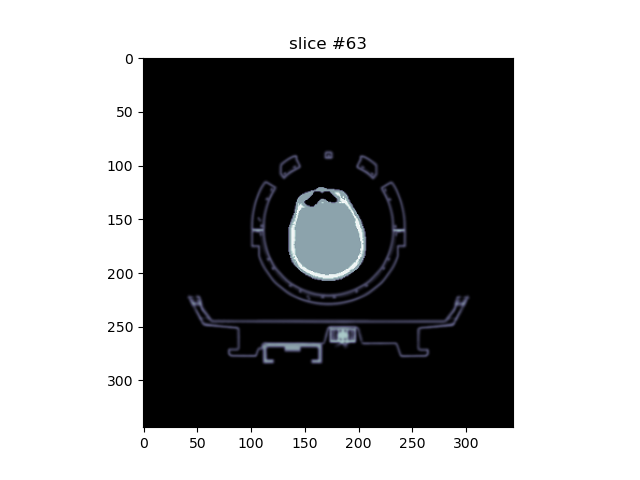

In [7]:
try:  # needs HW mu-maps
    imscroll(mu_o['im'] + mu_h['im'], cmap='bone')  # title=r"$\mu$-map"
except:
    imscroll(mu_o['im'], cmap='bone')

<IPython.core.display.Javascript object>


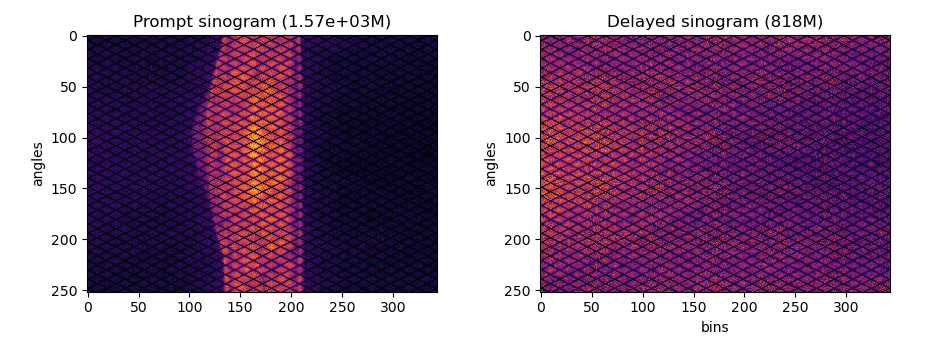

In [8]:
# sinogram index (<127 for direct sinograms, >=127 for oblique sinograms)
imscroll([m['psino'], m['dsino']],
         titles=["Prompt sinogram (%.3gM)" % (m['psino'].sum() / 1e6),
                 "Delayed sinogram (%.3gM)" % (m['dsino'].sum() / 1e6)],
         cmap='inferno',
         #colorbars=[1]*2,
         fig=plt.figure(figsize=(9.5, 3.5), tight_layout=True, frameon=False));
axs = plt.gcf().axes
axs[-1].set_xlabel("bins")
[i.set_ylabel("angles") for i in axs];

## Reconstruction

### OSEM

In [9]:
# built-in default: 14 subsets
fcomment = f"_fwhm-{fwhm}_recon"
outpath = path.join(opth, folderout)
recon = glob(
    f"{outpath}/PET/single-frame/a_t-*-*sec_itr-{itr}{fcomment}.nii.gz"
)
if recon:
    recon = {'fpet': recon[0], 'im': getnii(recon[0])}
else:
    recon = nipet.mmrchain(
        datain, mMRpars,
        #frames=['timings', [3000, 3600]],
        itr=itr,
        #store_itr=range(itr),
        histo=m,
        mu_h=mu_h,
        mu_o=mu_o,
        psf=fwhm,
        #recmod=1,  # no scatter & rand
        outpath=outpath,
        fcomment=fcomment,
        store_img=True)

#### Registration

In [10]:
# convert DCM to NII if required
if 'T1nii' not in datain:
    !{mMRpars['Cnt']['DCM2NIIX']} -z y -f 'T1' {datain['T1DCM']}
    extra = nipet.classify_input(datain['T1DCM'], mMRpars)
    extra.pop('corepath')
    datain.update(extra)

#filepaths = sorted(glob(path.join(datain['T1DCM'], '*.IMA')))
#arr = np.asanyarray([pydicom.dcmread(i).pixel_array for i in filepaths]).transpose(1, 2, 0)

In [11]:
# SPM12
regout = f"{opth}/affine_ref-a_t-*sec_itr-21_fwhm-4.5_recon.nii.gz"
regim = getnii(regout) if path.exists(regout) else register_spm(recon['fpet'], datain['T1nii'], opth)

# Simple Alternative: DIPY CoM
#regim = register_dipy(recon['fpet'], datain['T1nii'])

INFO:spm12.regseg:matrix M given in the form of Numpy array


#### Figures

<IPython.core.display.Javascript object>


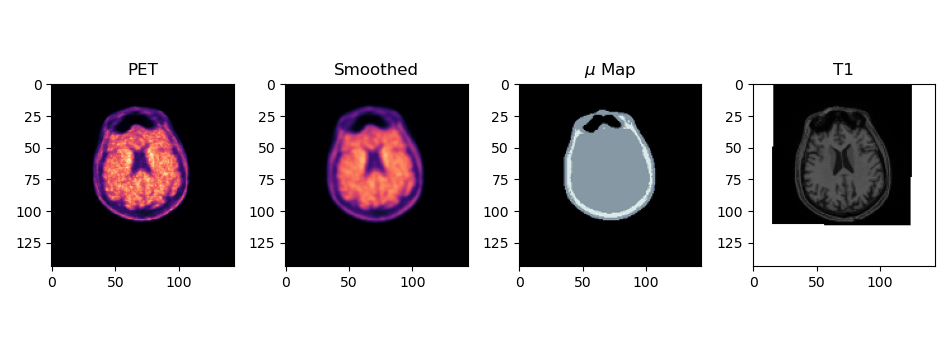

In [12]:
vmax = np.percentile(recon['im'], 99.95)
imscroll({
    "PET": mapVol(trimVol(recon['im']), 'magma', vmax=vmax),
    "Smoothed": mapVol(gaussian_filter(trimVol(recon['im']), 4.5 / SIGMA2FWHMmm), 'magma', vmax=vmax),
    "$\\mu$ Map": mapVol(trimVol(mu_o['im']), 'bone'),
    "T1": mapVol(trimVol(regim), 'Greys_r'),
},
fig=plt.figure(figsize=(9.5, 3.5), tight_layout=True, frameon=False),
);

<IPython.core.display.Javascript object>


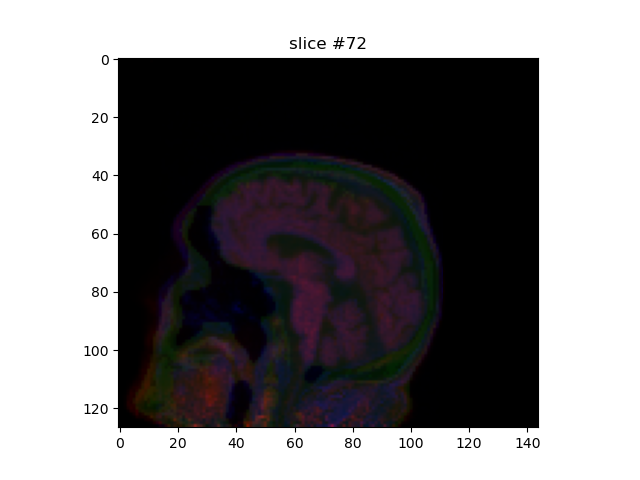

In [13]:
# rgb => PET, mu_o, T1
def norMax(x, scale=1):
    x = trimVol(x).transpose(2, 0, 1)[..., None]
    return x * (scale / x[~np.isnan(x)].max())
imscroll([np.concatenate([norMax(recon['im']), norMax(mu_o['im'], 0.15), norMax(regim, 0.75)], axis=-1)]);

### MLEM

In [14]:
## Attenuation, Normalisation & Sensitivity

A = nipet.frwd_prj(mu_o['im'], mMRpars, attenuation=True)
N = nipet.mmrnorm.get_norm_sino(datain, mMRpars, m)
AN = A * N
sim = nipet.back_prj(AN, mMRpars)
msk = nipet.img.mmrimg.get_cylinder(mMRpars['Cnt'], rad=29., xo=0., yo=0., unival=1, gpu_dim=False) <= 0.9

## Randoms

r = nipet.randoms(m, mMRpars)[0]
print("Randoms: %.3g%%" % (r.sum() / m['psino'].sum() * 100))

## Scatter

# One OSEM iteration estimate (implicitly using voxel-driven scatter model)
eim = nipet.mmrchain(datain, mMRpars, mu_o=mu_o, histo=m, itr=1, outpath=opth)['im']

# Recalculate scatter
s = nipet.vsm(datain, (np.zeros_like(mu_o['im']), mu_o['im']), eim, mMRpars, m, r)
print("Scatter: %.3g%%" % (s.sum() / m['psino'].sum() * 100))

INFO:niftypet.nipet.img.auximg:using object mu-map from dictionary
INFO:niftypet.nipet.img.auximg:using hardware mu-map from dictionary
INFO:niftypet.nipet.img.pipe:using the provided mu-map the same way for all frames.
INFO:niftypet.nipet.img.pipe:dynamic frame times t0=0, t1=3601:
INFO:niftypet.nipet.img.pipe:------------------------------------------------------
using provided histogram
------------------------------------------------------
INFO:niftypet.nipet.prj.mmrrec:reconstruction in mode: 3


Randoms: 52.1%


INFO:niftypet.nipet.prj.mmrrec:------ OSEM (1) -------
INFO:niftypet.nipet.mmraux:got LM interfile.
INFO:niftypet.nipet.mmraux:got CSA info.


OSEM:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:niftypet.nipet.prj.mmrrec:recon time: 7.3
INFO:niftypet.nipet.prj.mmrrec:applying decay correction of: 1.2014266465888763
INFO:niftypet.nipet.prj.mmrrec:applying quantification factor: 5570.410609255673 to the whole image
INFO:niftypet.nipet.prj.mmrrec:for the frame duration of: 3601


Scatter: 13.7%


<IPython.core.display.Javascript object>


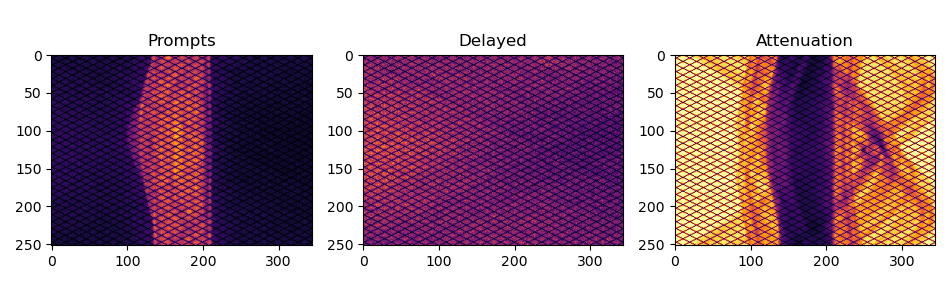

<IPython.core.display.Javascript object>


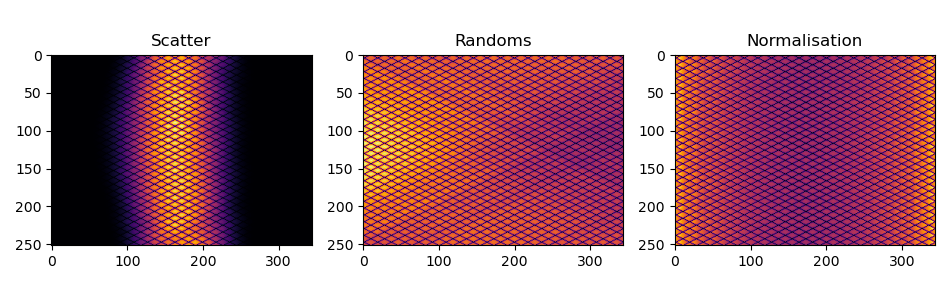

In [15]:
imscroll(OrderedDict([("Prompts", m['psino']), ("Delayed", m['dsino']), ("Attenuation", A)]),
         cmap='inferno', fig=plt.figure(figsize=(9.5, 3), tight_layout=True, frameon=False));
imscroll(OrderedDict([("Scatter", s), ("Randoms", r), ("Normalisation", N)]),
         cmap='inferno', fig=plt.figure(figsize=(9.5, 3), tight_layout=True, frameon=False));

In [16]:
## MLEM with RM

psf = functools.partial(gaussian_filter, sigma=fwhm / SIGMA2FWHMmm)
sim_inv = div_nzer(1, psf(sim))
sim_inv[msk] = 0
rs_AN = div_nzer(r + s, AN)
recon_mlem = [np.ones_like(sim)]
for k in trange(itr * 14, desc="MLEM"):
    fprj = nipet.frwd_prj(psf(recon_mlem[-1]), mMRpars) + rs_AN
    recon_mlem.append(recon_mlem[-1] * sim_inv * psf(nipet.back_prj(div_nzer(m['psino'], fprj), mMRpars)))

MLEM:   0%|          | 0/98 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


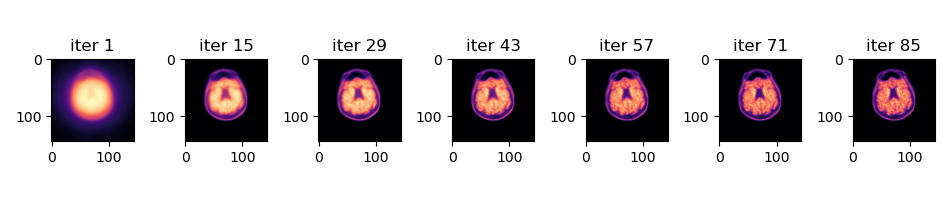

In [17]:
# central slice across iterations
imscroll(
    np.asanyarray([trimVol(i) for i in recon_mlem[1::14]]),
    titles=["iter %d" % i for i in range(1, len(recon_mlem), 14)],
    cmap='magma', fig=plt.figure(figsize=(9.5, 2), tight_layout=True, frameon=False));